In [41]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip


In [42]:
!pip install pyproj==1.9.6

# BIBLIOTECAS

In [43]:
!apt-get install libproj-dev proj-data proj-bin  
!apt-get install libgeos-dev  
!pip install cython  
!pip install cartopy  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [44]:
!pip install wrf-python

In [45]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

import pandas as pd
from numpy import loadtxt,meshgrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import callbacks
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
%matplotlib inline
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
import numpy as np
from numpy import loadtxt,meshgrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import callbacks
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
%matplotlib inline
from mpl_toolkits.basemap import Basemap, cm, interp
from numpy import linspace
from scipy.interpolate import griddata,interp2d
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
from wrf import smooth2d

# DATASET

In [10]:
df_TRAIN = pd.read_csv('drive/My Drive/dados_jan1979_jan2020/data.csv', delimiter=',',header=0)

In [11]:
df_GEN = pd.read_csv('drive/My Drive/dados_jan1979_jan2020/data.csv', delimiter=',',header=0)

In [12]:
df_TRAIN.head()

,Unnamed: 0,lat,lon,press,year,month,shum850,temp850,u200,u850,v200,v850,ErrorEstimate,prec_gpcp
0,0,20.0,270.0,1018.86456,1979,1,7.966999,14.820007,16.470001,-1.600006,3.639999,1.050003,1.378878,2.921673
1,1,20.0,270.0,1019.77150,1979,2,7.476000,14.310005,25.539993,-2.639999,8.369995,1.360001,1.609161,3.810162
2,2,20.0,270.0,1017.90990,1979,3,8.541000,16.170006,24.630005,-2.729996,2.220001,1.949997,1.466622,3.253795
3,3,20.0,270.0,1014.48004,1979,4,8.826000,18.380005,20.069992,-2.639999,4.300003,3.649994,1.707970,4.207407
4,4,20.0,270.0,1014.12585,1979,5,9.740999,19.080002,23.119995,-1.779999,-2.660004,2.000000,1.259363,2.482859


# PREPROCESSAMENTO

In [13]:
df_TRAIN.loc[df_TRAIN['month']==12,'year']=df_TRAIN.loc[df_TRAIN['month']==12,'year']+1
df_TRAIN.shape

(471801, 14)

In [14]:
df_GEN.loc[df_GEN['month']==12,'year']=df_GEN.loc[df_GEN['month']==12,'year']+1
df_GEN.shape

(471801, 14)

In [15]:
df_TRAIN["year"] = pd.to_numeric(df_TRAIN["year"])
df_TRAIN["month"] = pd.to_numeric(df_TRAIN["month"])

In [16]:
_X_TRAIN = df_TRAIN[(df_TRAIN['year']>=1979)&(df_TRAIN['year']<=2016)][(df_TRAIN['month']==12) | (df_TRAIN['month']==1) | (df_TRAIN['month']==2)]
_Y_TRAIN = df_TRAIN[(df_TRAIN['year']>=1979)&(df_TRAIN['year']<=2016)][(df_TRAIN['month']==3) | (df_TRAIN['month']==4) | (df_TRAIN['month']==5)]

_X_TRAIN.shape,_Y_TRAIN.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


((108141, 14), (109098, 14))

In [17]:
_X_GEN = df_GEN[(df_GEN['year']>=2017)&(df_GEN['year']<=2019)][(df_GEN['month']==12) | (df_GEN['month']==1) | (df_GEN['month']==3)]
_Y_GEN = df_GEN[(df_GEN['year']>=2017)&(df_GEN['year']<=2019)][(df_GEN['month']==3) | (df_GEN['month']==4) | (df_GEN['month']==5)]

_X_GEN.shape,_Y_GEN.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


((8613, 14), (8613, 14))

In [18]:
X_TRAIN=_X_TRAIN.groupby(['year','lat','lon']).mean().reset_index()[['year','month','lat','lon','u200','u850','v200','v850','shum850','temp850', 'press' ,'prec_gpcp']].values
Y_TRAIN=_Y_TRAIN.groupby(['year','lat','lon']).mean().reset_index()[['prec_gpcp']].values

print(X_TRAIN.shape)
print(Y_TRAIN.shape)

(36366, 12)
(36366, 1)


In [19]:
print(_X_TRAIN.groupby(['year','lat','lon']).size())
print(_Y_TRAIN.groupby(['year','lat','lon']).size())

year  lat    lon  
1979  -60.0  270.0    2
             272.5    2
             275.0    2
             277.5    2
             280.0    2
                     ..
2016   20.0  330.0    3
             332.5    3
             335.0    3
             337.5    3
             340.0    3
Length: 36366, dtype: int64
year  lat    lon  
1979  -60.0  270.0    3
             272.5    3
             275.0    3
             277.5    3
             280.0    3
                     ..
2016   20.0  330.0    3
             332.5    3
             335.0    3
             337.5    3
             340.0    3
Length: 36366, dtype: int64


In [20]:
X_GEN=_X_GEN.groupby(['year','lat','lon']).mean().reset_index()[['year','month','lat','lon','u200','u850','v200','v850','shum850','temp850', 'press' ,'prec_gpcp']].values
y_gen=_Y_GEN.groupby(['year','lat','lon']).mean().reset_index()[['prec_gpcp']].values

X_gen = _X_GEN.groupby(['year','lat','lon']).mean().reset_index()[['year','month','lat','lon','u200','u850','v200','v850','shum850','temp850', 'press' ,'prec_gpcp']]
print(X_gen.shape)

(2871, 12)


In [21]:
print(_X_GEN.groupby(['year','lat','lon']).size())
print(_Y_GEN.groupby(['year','lat','lon']).size())

year  lat    lon  
2017  -60.0  270.0    3
             272.5    3
             275.0    3
             277.5    3
             280.0    3
                     ..
2019   20.0  330.0    3
             332.5    3
             335.0    3
             337.5    3
             340.0    3
Length: 2871, dtype: int64
year  lat    lon  
2017  -60.0  270.0    3
             272.5    3
             275.0    3
             277.5    3
             280.0    3
                     ..
2019   20.0  330.0    3
             332.5    3
             335.0    3
             337.5    3
             340.0    3
Length: 2871, dtype: int64


In [22]:
X_dev, y_dev = shuffle(X_TRAIN, Y_TRAIN, random_state=0)

print(X_dev.shape)
print(y_dev.shape)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.30)

scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_stand = scaler.transform(X_train)
X_val_stand = scaler.transform(X_val)
X_gen_stand = scaler.transform(X_GEN)

(36366, 12)
(36366, 1)


# TREINAMENTO

In [23]:
def get_model():
  model = Sequential()
  model.add(Dense(25, input_dim=12, activation='relu'))
  # model.add(Dropout(0.1))
  model.add(Dense(25, activation='relu'))
  # model.add(Dropout(0.1))
  model.add(Dense(1, activation='linear'))
  return model

In [24]:
# define the keras model
model=get_model()

# compile the keras model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history=model.fit(X_train_stand,
                          y_train.ravel(),
                          validation_data=(X_val_stand,y_val),
                          batch_size=100,
                          epochs=1000,
                          verbose=2,
                          callbacks=[callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=100,
                                                             restore_best_weights=True)])

Epoch 1/1000
255/255 - 1s - loss: 7.1954 - mse: 7.1954 - val_loss: 4.5779 - val_mse: 4.5779
Epoch 2/1000
255/255 - 0s - loss: 3.5760 - mse: 3.5760 - val_loss: 2.8677 - val_mse: 2.8677
Epoch 3/1000
255/255 - 0s - loss: 2.7455 - mse: 2.7455 - val_loss: 2.4367 - val_mse: 2.4367
Epoch 4/1000
255/255 - 0s - loss: 2.2933 - mse: 2.2933 - val_loss: 2.0682 - val_mse: 2.0682
Epoch 5/1000
255/255 - 0s - loss: 2.0413 - mse: 2.0413 - val_loss: 1.9189 - val_mse: 1.9189
Epoch 6/1000
255/255 - 0s - loss: 1.8956 - mse: 1.8956 - val_loss: 1.8015 - val_mse: 1.8015
Epoch 7/1000
255/255 - 0s - loss: 1.7647 - mse: 1.7647 - val_loss: 1.6976 - val_mse: 1.6976
Epoch 8/1000
255/255 - 0s - loss: 1.6519 - mse: 1.6519 - val_loss: 1.5695 - val_mse: 1.5695
Epoch 9/1000
255/255 - 0s - loss: 1.5598 - mse: 1.5598 - val_loss: 1.4978 - val_mse: 1.4978
Epoch 10/1000
255/255 - 0s - loss: 1.4878 - mse: 1.4878 - val_loss: 1.4773 - val_mse: 1.4773
Epoch 11/1000
255/255 - 0s - loss: 1.4295 - mse: 1.4295 - val_loss: 1.3751 - va

In [25]:
model.evaluate(X_train_stand,y_train)
model.evaluate(X_val_stand,y_val)
model.evaluate(X_gen_stand,y_gen)

90/90 [==============================] - 0s 917us/step - loss: 0.7759 - mse: 0.7759


[0.7758537530899048, 0.7758537530899048]

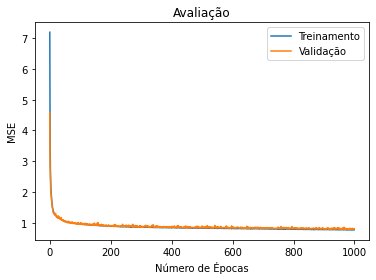

In [26]:
plt.plot(history.history['mse'], label ='Treinamento')
plt.plot(history.history['val_mse'],label ='Validação')
plt.xlabel('Número de Épocas')
plt.ylabel('MSE')
plt.title("Avaliação")
plt.legend()

In [27]:
z_pred=model.predict(X_gen_stand)

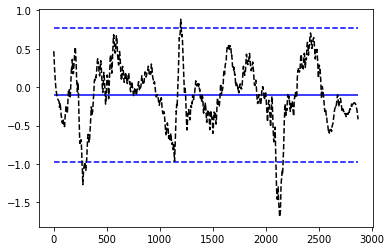

In [28]:
from scipy import signal

ERROR=y_gen-z_pred

ERROR_SMOOTH=signal.savgol_filter(ERROR,99,3,axis=0)

plt.plot(ERROR_SMOOTH, '--', color='black')
plt.hlines(ERROR.mean(),xmin=0,xmax=ERROR.shape[0],linestyles='-',color='blue')
plt.hlines(ERROR.mean()+ERROR.std(),xmin=0,xmax=ERROR.shape[0],linestyles='--',color='blue')
plt.hlines(ERROR.mean()-ERROR.std(),xmin=0,xmax=ERROR.shape[0],linestyles='--',color='blue')

In [29]:
ERROR.mean(),ERROR.std()

(-0.10124842616185868, 0.874987049779296)

In [30]:
results = X_gen.copy()
results['y_gen'] = y_gen
results['z_pred'] = z_pred
print(results.head())

filename = 'resultsMAM.csv'
results.to_csv(filename)

# from google.colab import files
# files.download(filename)

   year     month   lat    lon  ...       press  prec_gpcp     y_gen    z_pred
0  2017  5.333333 -60.0  270.0  ...  991.012600   1.832719  2.725072  2.552844
1  2017  5.333333 -60.0  272.5  ...  992.723413   1.404413  2.038939  2.109353
2  2017  5.333333 -60.0  275.0  ...  994.309433   0.835634  1.131833  1.744447
3  2017  5.333333 -60.0  277.5  ...  994.293247   0.650830  1.081298  1.818366
4  2017  5.333333 -60.0  280.0  ...  992.933633   0.685796  3.080741  1.958168

[5 rows x 14 columns]


# GRÁFICOS

In [31]:
# dataset_1981=dataset[dataset.ANO==1981]
# _y=dataset_1981[['LAT']][:]
# _x=dataset_1981[['LON']][:]
# _z=dataset_1981[['PREC']][:]

In [32]:
_y=X_gen[['lat']]
_x=X_gen[['lon']]
_z=y_gen

print(_x)
print(_y)
print(_z.shape)

        lon
0     270.0
1     272.5
2     275.0
3     277.5
4     280.0
...     ...
2866  330.0
2867  332.5
2868  335.0
2869  337.5
2870  340.0

[2871 rows x 1 columns]
       lat
0    -60.0
1    -60.0
2    -60.0
3    -60.0
4    -60.0
...    ...
2866  20.0
2867  20.0
2868  20.0
2869  20.0
2870  20.0

[2871 rows x 1 columns]
(2871, 1)


In [33]:
_z.shape,z_pred.shape

((2871, 1), (2871, 1))

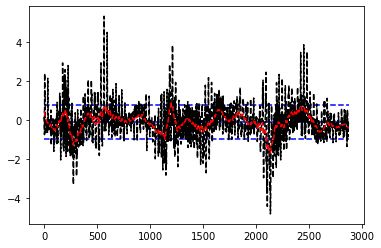

In [37]:
from scipy import signal

ERROR = _z.ravel() - z_pred.ravel()

ERROR_SMOOTH=signal.savgol_filter(ERROR,99,3,axis=0)

plt.plot(ERROR, '--', color='black')
plt.plot(ERROR_SMOOTH, '--', color='red')
plt.hlines(ERROR.mean(),xmin=0,xmax=ERROR.shape[0],linestyles='-',color='blue')
plt.hlines(ERROR.mean()+ERROR.std(),xmin=0,xmax=ERROR.shape[0],linestyles='--',color='blue')
plt.hlines(ERROR.mean()-ERROR.std(),xmin=0,xmax=ERROR.shape[0],linestyles='--',color='blue')

In [47]:
import numpy as np
# generate grid data
numcols, numrows =  100, 100
xi = np.linspace(270, 340, numcols)
yi = np.linspace(-60, 20, numrows)
xi, yi = np.meshgrid(xi, yi)

# interpolate, there are better methods, especially if you have many datapoints
zi = griddata((_x.values.ravel(),_y.values.ravel()), _z.ravel() - z_pred.ravel(), (xi,yi), method='nearest', fill_value=0)

zi_smooth=smooth2d(zi, 3, cenweight=4)

# Create a figure
fig = plt.figure(figsize=(15,10))

ax = plt.axes(projection=crs.PlateCarree())

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# plt.contour(xi, yi, zi,range(1, 21,5),transform=crs.PlateCarree())
plt.contourf(xi, yi, zi_smooth,range(-10, 10,1),
             transform=crs.PlateCarree(),
            #  cmap=get_cmap("Greys"))
             cmap=get_cmap("jet"))

# # Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# # Set the map bounds
ax.set_xlim(-80,-30)
ax.set_ylim(-40,8)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Precipitação")

plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: ignored

<Figure size 1080x720 with 2 Axes>

In [39]:
zi = griddata((_x.values.ravel(),_y.values.ravel()),_z.ravel(),(xi,yi),method='nearest',fill_value=0)

zi_smooth=smooth2d(zi, 3, cenweight=4)

# Create a figure
fig = plt.figure(figsize=(15,10))

ax = plt.axes(projection=crs.PlateCarree())

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# plt.contour(xi, yi, zi,range(1, 21,5),transform=crs.PlateCarree())
plt.contourf(xi, yi, zi_smooth,range(0, 15,1),
             transform=crs.PlateCarree(),
            #  cmap=get_cmap("Greys"))
             cmap=get_cmap("jet"))

# # Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# # Set the map bounds
ax.set_xlim(-80,-30)
ax.set_ylim(-40,8)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Precipitation GPCP")

plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: ignored

<Figure size 1080x720 with 2 Axes>

In [40]:
z_pred[z_pred < 0] = 0

zi = griddata((_x.values.ravel(),_y.values.ravel()),z_pred.ravel(),(xi,yi),method='nearest',fill_value=0)

zi_smooth=smooth2d(zi, 3, cenweight=4)

# Create a figure
fig = plt.figure(figsize=(15,10))

ax = plt.axes(projection=crs.PlateCarree())

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# plt.contour(xi, yi, zi,range(1, 21,5),transform=crs.PlateCarree())
plt.contourf(xi, yi, zi_smooth,range(0, 15,1),
             transform=crs.PlateCarree(),
            #  cmap=get_cmap("Greys"))
             cmap=get_cmap("jet"))

# # Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# # Set the map bounds
ax.set_xlim(-80,-30)
ax.set_ylim(-40,8)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Precipitação")

plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_shp.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


HTTPError: ignored

<Figure size 1080x720 with 2 Axes>

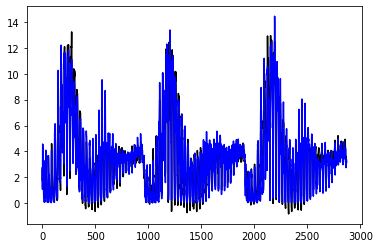

In [38]:
from scipy import signal

plt.plot(z_pred.ravel(), '-', color='black')
plt.plot(_z.ravel(), '-', color='blue')

In [ ]:
np.isnan(z_pred)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

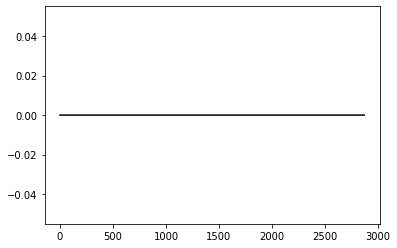

In [ ]:
from scipy import signal

plt.plot(np.isnan(z_pred), '-', color='black')